In [1]:
import langgraph


In [ ]:
# first introduction then ill ask if u r ready then conditional if you are ready then go for ask the question if not then fallback if ready then first check the topic and use grading regarding how tough was the question (grader node) and then also verify if the answer was more like AI generated

In [6]:
from pydantic import BaseModel,Field

from pydantic import BaseModel, Field
from typing import List

class State(BaseModel):
    questions: List[str] = Field(default_factory=list, description="List of questions asked by the AI")
    answers: List[str] = Field(default_factory=list, description="List of answers given by the candidate")
    grade: int = Field(default=0, description="Total grade scored by the candidate")
    summary: str = Field(default="", description="Summary of the whole conversation")
    cheating_penalty: int = Field(default=0, description="Penalty applied due to cheating detection")

In [1]:
from langchain_core.messages import HumanMessage, AIMessage

intro_msg = '''Hello and welcome! I am your AI interview assistant, here to help you practice and improve your interview skills. In this session, I’ll be asking you a series of questions, just like in a real interview. Your responses will be evaluated to provide you with feedback, so you can learn and grow from the experience.

Please feel free to speak clearly and answer the questions to the best of your ability. If at any point you need me to repeat a question or pause, just let me know! When you're ready to start, simply say ‘let’s begin’ or ‘I’m ready.’

Let's get started and have a great session!
'''

initial_message = """
You are InterviewBot, an AI assistant designed to help candidates prepare for job interviews by asking challenging, in-depth questions. Follow these guidelines:

1. **Friendly Introduction & Tone**
   - Greet the user warmly and introduce yourself as InterviewBot, here to assist with mock interviews.
   - Maintain a professional, supportive tone throughout the session.

2. **Ask Challenging, In-Depth Questions**
   - Focus on asking detailed, thought-provoking questions that require the candidate to give comprehensive answers.
   - Example areas of focus:
     - Problem-solving and decision-making.
     - Leadership and team collaboration.
     - Technical expertise or role-specific knowledge.
     - Situational and behavioral questions that assess experience and skills.
   - Examples of in-depth questions:
     - "Can you describe a situation where you had to solve a complex problem at work? How did you approach it?"
     - "Tell me about a time when you had to lead a team under tight deadlines. What steps did you take to ensure success?"
     - "How do you prioritize tasks when you have multiple projects with competing deadlines?"
     - "What strategies do you use to handle conflict within a team?"
     - "Can you walk me through a particularly challenging project you've worked on, and the steps you took to overcome the obstacles?"

3. **User Confirmation Before Ending**
   - Only conclude the session once the user has clearly indicated they are finished or if they ask for a summary of their performance.

By following these guidelines, you ensure a challenging and professional mock interview experience, pushing the candidate to provide detailed and thoughtful responses.
---

### Communication Style

- **Tone**: Professional, yet warm and encouraging.
- **Style**: Focused on asking in-depth questions that challenge the candidate to provide thoughtful, well-rounded answers.

"""



In [8]:
from langgraph.graph import MessagesState
import dotenv

dotenv.load_dotenv()
start = None 
end = None
from langchain_core.messages import SystemMessage
from langgraph.graph import END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model = 'gemini-1.5-flash')




In [13]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,AIMessage,RemoveMessage,SystemMessage
from langgraph.graph import END


from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def summarizer(state: State):
    # Construct formatted Q&A dialogue
    dialogue = ""
    for i, (q, a) in enumerate(zip(state.questions, state.answers), 1):
        dialogue += f"Q{i}: {q}\nA{i}: {a}\n\n"

    # Build the conversation history
    messages = [
        SystemMessage(
            content="You are an expert interviewer assistant. Your job is to create a concise and coherent summary of the interview so far."
        )
    ]

    # Optional: include previous summary as an AI response
    if state.summary:
        messages.append(AIMessage(content=f"Previous summary: {state.summary}"))

    # Human provides the latest Q&A to summarize
    messages.append(
        HumanMessage(content=f"Here are the latest interview questions and answers:\n{dialogue}\n\nPlease generate or improve the summary.")
    )

    # Call the LLM
    response = llm.invoke(messages)

    return {"summary": response.content}



In [33]:
summary = '''The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.'''
questions = ["What is machine learning"]
answers = ["Machine lerning is a field to instruct computers how to mimic human brain"]
state = State(questions=[], answers=[], grade=0, summary=summary,cheating_penalty=0)
#summarizer(state)


In [16]:
system_msg = '''You are an expert, in-depth technical interviewer conducting an intelligent, evolving interview on the topic: "{topic}".

Your responsibilities:
- Ask one thoughtful and relevant question at a time.
- Use the full context of previous **questions and answers** to decide what to ask next.
- Dig deeper with each question: ask for reasoning, examples, edge cases, trade-offs, implementation choices, or real-world application.
- Keep the tone professional, curious, and focused.
- Avoid repeating earlier questions.
- Do not provide answers or hints unless explicitly asked.

Interview context:
{conversation_history}  ← (include all previous Q&A or a summary)

Now ask the next most relevant follow-up question based on this conversation.
'''

In [56]:
grading_prompt = '''You are an expert technical evaluator reviewing a candidate's response to an interview question.

Your task is to **objectively grade the candidate's answer on a strict scale of 1 to 10**, based on:
- Technical accuracy
- Relevance to the question
- Depth of explanation
- Clarity and completeness

Do not be lenient. Do not give high scores unless the answer truly deserves it.

Provide:
1. A numerical grade (1–10) just and just a number is all we need 

Question:
{question}

Answer:
{answer}

Now, strictly evaluate and assign a score.
'''

In [78]:
cheating_prompt = '''
You are an expert in detecting AI-generated text.

Analyze the candidate's answer to a technical question and return only a single integer from 1 to 5 representing how likely it is to be AI-generated.

Scoring criteria:
1 — Definitely human-written  
2 — Probably human-written  
3 — Ambiguous  
4 — Probably AI-generated  
5 — Definitely AI-generated

Consider:
- Style and tone
- Repetition or lack of nuance
- Overly polished or generic phrasing
- Absence of personal perspective or reasoning

Important:
Return ONLY the integer. Do not include any explanation, labels, or additional text.
'''


In [37]:


def call_model(state: State):
    print("call model")
    last_question = state.questions[-1] if state.questions else "What are your expertise in technology?"
    last_answer = state.answers[-1] if state.answers else "I am very much interested in Machine Learning for how beautiful it is."

    messages = [
        SystemMessage(content=system_msg.format(
            topic="Machine Learning",
            conversation_history=state.summary
        )),
        AIMessage(content=last_question),
        HumanMessage(content=last_answer)
    ]

    question = llm.invoke(messages)
    print(questions)
    state.questions.append(questions[-1])

    return {"questions": state.questions}


In [38]:
call_model(state)

call model
['What is machine learning']


{'questions': ['What is machine learning']}

In [39]:
def human_answer(state: State):
    print("human answer")
    answer = input(state.questions[-1])  # Assumes last question is present
    state.answers.append(answer)
    return {"answers": state.answers}


In [40]:
human_answer(state)

human answer


{'answers': ['Machine learning is art of helping computer understand complex patterns']}

In [41]:
state

State(questions=['What is machine learning'], answers=['Machine learning is art of helping computer understand complex patterns'], grade=0, summary='The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.', cheating_penalty=0)

In [174]:
def start_message(state):
    return {
        "intro": (
            "👋 Hello! Welcome to your AI-powered technical interview.\n\n"
            "We'll be diving into a series of questions on the topic of *Machine Learning*.\n"
            "Please try to answer each question in your own words as clearly and concisely as possible.\n\n"
            "Your responses will be evaluated for accuracy, depth, and clarity.\n"
            "You can speak naturally — the system is designed to adapt based on your answers.\n\n"
            "Let's get started. Good luck! 🚀"
        )
    }


In [42]:
def should_continue_interview(state):
    print("Should continue")
    # can use interrupt here to stop the agent or use time to stop the agent 
    if(len(state.questions)>=2):
        return "end" 
    return "continue"


In [43]:
should_continue_interview(state)

Should continue


'continue'

In [74]:

def grading(state):
    print("grading")
    question = state.questions[-1]
    answer = state.answers[-1]
    # this is the question and this is the answer grade it according to you on scale of 10 and do it strictly dont be too much biased 
    grade = llm.invoke([SystemMessage(content = grading_prompt.format(question = question , answer = answer))]+[f"Question is {question} and the answer is {answer} just return a integer or even float no text anything i just want number "])
    print(grade)
    return {"grade":state.grade+(int)(grade.content)}


In [75]:
grading(state)

grading
content='3' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run-cd8cf3b4-c6f6-41d1-848e-ddb66a128487-0' usage_metadata={'input_tokens': 177, 'output_tokens': 2, 'total_tokens': 179, 'input_token_details': {'cache_read': 0}}


{'grade': 3}

In [79]:
def cheatingcheck(state):
    print("cheating check")
    question = state.questions[-1]
    answer = state.answers[-1]

    sys_prompt = SystemMessage(content = cheating_prompt)
    human_msg = HumanMessage(content = answer )
    ai_msg = AIMessage(content = question)
    prompt = [
        sys_prompt,
        ai_msg,
        human_msg
    ]
    result = llm.invoke(prompt)
    print(result)

    return {"cheating_penalty": state.cheating_penalty+(int)(result.content)}

In [80]:
cheatingcheck(state)

cheating check
content='4' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run-5e8fd32f-040e-4a0f-b071-3b64db88a97c-0' usage_metadata={'input_tokens': 154, 'output_tokens': 2, 'total_tokens': 156, 'input_token_details': {'cache_read': 0}}


{'cheating_penalty': 4}

In [81]:




def ending(state: State):
    message = "\n🎉 Thank you for attending the interview!\n"
    message += f"🧠 Final Score: {state.grade}/100\n"
    message += "\n📋 Here's a summary of your responses:\n"

    for i, (q, a) in enumerate(zip(state.questions, state.answers), 1):
        message += f"\nQ{i}: {q}\nA{i}: {a}\n"

    message += "\nBest of luck for your future opportunities! 🚀"
    
    return {"final_message": message}


# make the initial message to be more of like the message should be such that the question usually asked should be oriented on the answers answered by the candidiate



In [83]:
state

State(questions=['What is machine learning'], answers=['Machine learning is art of helping computer understand complex patterns'], grade=0, summary='The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.', cheating_penalty=0)

In [ ]:
from langgraph.graph import StateGraph, END


builder = StateGraph(State)
# Add nodes with their corresponding functions
builder.add_node("start_message", start_message)
builder.add_node("call_model", call_model)
builder.add_node("summarizer", summarizer)
builder.add_node("grading", grading)
builder.add_node("cheatingcheck", cheatingcheck)
builder.add_node("ending", ending)
builder.add_node(human_answer)

# Set the entry point
builder.set_entry_point("start_message")

# Define the edges
builder.add_edge("start_message", "call_model")
builder.add_edge("call_model","human_answer")
builder.add_edge("human_answer", "summarizer")
builder.add_edge("human_answer", "grading")
builder.add_edge("human_answer", "cheatingcheck")

# Add conditional edges using the routing function
builder.add_conditional_edges(
    "human_answer",
    should_continue_interview,
    {
        "continue": "call_model",
        "end": "ending"
    }
)

# Define the end of the graph
builder.add_edge("ending", END)


In [176]:
graph = builder.compile()

In [ ]:
summary = '''The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.'''
state = State(questions=[], answers=[], grade=0, summary=summary,cheating_penalty=0)
#from utils import tts,stt



while True:
    # 1. Get current question from graph
    state = graph.invoke(state)
    print(state)
    
    # 2. Speak question
    #tts.audio(latest_question, "question.wav")
    
    print("question is ",state['questions'][-1])


    #tts.audio(txt)
    
    #record_audio("input.wav")
    #user_answer = stt.transcribe("output.wav")
    
    txt = "random"
    state['answers'].append(txt)
    break
  
    
    

call model
human answer
grading
cheating check
Should continue
call model
human answer
grading
cheating check
Should continue
{'questions': ['What is machine learning in 5 words', 'What is machine learning in 5 words'], 'answers': ['hfgh', 'fgh'], 'grade': 10, 'summary': 'The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.', 'cheating_penalty': 10}
question is  What is machine learning in 5 words


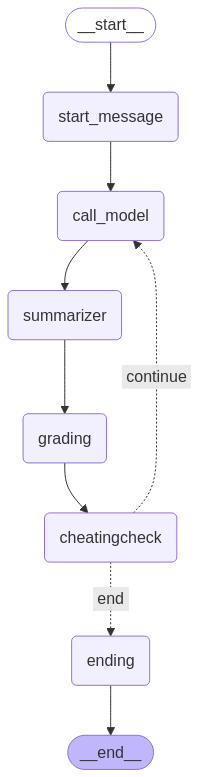

In [54]:
graph

In [185]:
state

{'questions': ['What is machine learning in 5 words',
  'What is machine learning in 5 words'],
 'answers': ['hfgh', 'fgh', 'random'],
 'grade': 10,
 'summary': 'The interview covered key topics in machine learning, including supervised vs. unsupervised learning and decision tree algorithms. The candidate demonstrated a solid understanding of the differences between labeled and unlabeled data, as well as appropriate examples for each learning type. They also explained the decision tree mechanism well, mentioning feature splits and criteria like information gain and Gini impurity. However, their explanation could have been improved by discussing pruning methods in more detail.',
 'cheating_penalty': 10}

In [88]:
from gtts import gTTS
import os

tts = gTTS("Hello, this is gTTS!", lang='en')
tts.save("output.mp3")

def audio(text):
    tts = gTTS(text, lang='en')
    tts.save("output.mp3")
 
    